In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
import cudf as gd
from cuml.manifold.umap import UMAP as cumlUMAP
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.autonotebook import tqdm
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
from avgn.utils.paths import FIGURE_DIR, ensure_dir
from avgn.utils.general import save_fig

In [5]:
DATASET_ID = 'buckeye'

In [6]:
window_loc = DATA_DIR / "umap_windows/buckeye/then_they_them_that_12.pickle"

In [7]:
words_df = pd.read_pickle(window_loc)

In [8]:
words_df[:3]

,start_time,end_time,word,phones,phone_start_times,phone_end_times,utterance_number,position_in_utterance,word_number,indv,indvi,age,sex,key,rate,spectrogram,windows
4,25.588546,25.778605,they,"[dh, ey]","[0.0, 0.06714699999999851]","[0.06714699999999851, 0.19005899999999798]",10,4,4,s25,0,o,f,s2501b,16000,"[[2, 2, 1, 0, 15, 24, 25, 18, 6, 1, 0, 36, 144...","[[[2, 37, 40, 40, 48, 39, 44, 35, 18, 20, 11, ..."
26,33.108949,33.305837,they,"[dh, ey]","[0.0, 0.08692599999999828]","[0.08692599999999828, 0.19688799999999418]",11,6,6,s25,0,o,f,s2501b,16000,"[[167, 184, 187, 179, 176, 174, 170, 163, 162,...","[[[167, 140, 106, 117, 114, 108, 118, 108, 80,..."
42,41.209772,41.342922,that,"[dh, eh, t]","[0.0, 0.04551800000000128, 0.10583599999999649]","[0.04551800000000128, 0.10583599999999649, 0.1...",32,11,11,s25,0,o,f,s2501b,16000,"[[133, 155, 158, 150, 131, 112, 93, 83, 72, 52...","[[[133, 167, 96, 78, 103, 116, 110, 100, 97, 9..."


In [9]:
indv_count = pd.DataFrame({i:[sum(words_df.indv ==i)] for i in  words_df.indv.unique()}).T.sort_values(by=0, ascending=False)[:20].T
indv_count

,s16,s13,s18,s19,s12,s25,s10,s02,s08,s07,s35,s30,s38,s40,s29,s14,s24,s22,s09,s39
0,572,474,449,417,414,402,392,382,369,345,339,327,322,316,302,300,297,287,273,270


In [10]:
words_df = words_df[words_df.indv == 's16']

In [11]:
len(words_df)

572

In [12]:
word_group = '_'.join(words_df.word.unique())
word_group

'them_that_they_then'

In [13]:
FIG_SAVE_LOC = FIGURE_DIR/'umap_seqs' / DATASET_ID / word_group
ensure_dir(FIG_SAVE_LOC)

In [14]:
pd.DataFrame({i:[sum(words_df.indv ==i)] for i in  words_df.indv.unique()})

,s16
0,572


In [15]:
np.unique(np.concatenate(words_df.phones.values))

array(['ae', 'ah', 'ch', 'd', 'dh', 'dx', 'eh', 'em', 'en', 'ey', 'ih',
       'iy', 'l', 'm', 'n', 'p', 's', 't', 'tq', 'uw', 'z'], dtype='<U2')

In [16]:
n_windows = [len(row.windows) for idx, row in words_df.iterrows()]
words = np.concatenate([np.repeat(row.word, len(row.windows)) for idx, row in words_df.iterrows()])

In [17]:
n_windows[:5]

[32, 47, 29, 31, 34]

In [18]:
# get beginnings and endings of each sequence
onsets = [0]
offsets = [n_windows[0]-1]
for wd in n_windows[1:]:
    onsets.append(offsets[-1]+1)
    offsets.append(onsets[-1]+wd-1)
onsets[:5], offsets[:5], len(onsets), len(offsets)

([0, 32, 79, 108, 139], [31, 78, 107, 138, 172], 572, 572)

In [19]:
{i:sum(words == i) for i in np.unique(words)}

{'that': 9238, 'them': 3478, 'then': 2379, 'they': 7731}

In [20]:
words[:10]

array(['them', 'them', 'them', 'them', 'them', 'them', 'them', 'them',
       'them', 'them'], dtype='<U4')

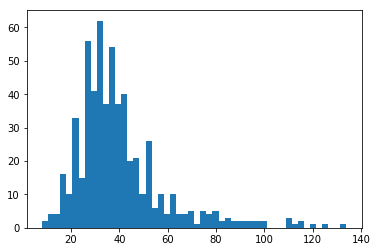

In [21]:
plt.hist(n_windows, bins=50);

In [22]:
rate = 16000

In [23]:
windows = np.vstack(list(words_df.windows))
print(np.shape(windows))
windows = np.reshape(windows, (len(windows), np.prod(np.shape(windows)[1:])))
print(np.shape(windows))

(22826, 3, 32)
(22826, 96)


In [24]:
cuml_umap = cumlUMAP(min_dist = 0.25)
embedding = cuml_umap.fit_transform(windows)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  


(-15, 15)

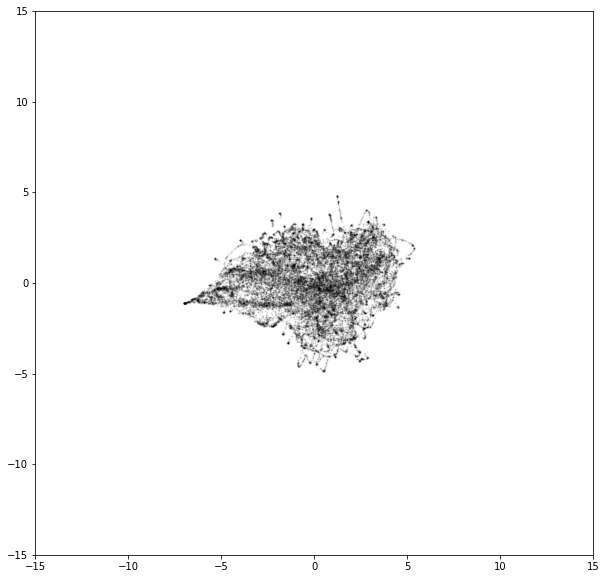

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:,0], embedding[:,1], alpha = 0.1, s = 1, color='k')
ax.set_xlim([-15,15])
ax.set_ylim([-15,15])

### plot over time

In [29]:
savefig = False

In [30]:
from avgn.visualization.projections import colorline

In [31]:
xlims = [-10,7]
ylims = [-6,6]

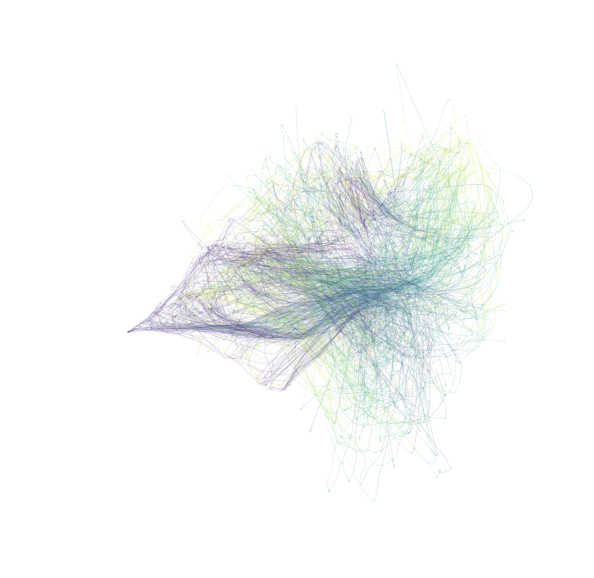

In [32]:
fig, ax = plt.subplots(figsize=(10,10))
#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]
#ax.legend(markers, word_pal.keys(), numpoints=1)


for oi, (on, off) in enumerate(tqdm(zip(onsets, offsets), total=len(offsets))):
    window_z = embedding[on:off,:]
    cols = np.array(sns.color_palette('viridis', len(window_z)))
    #ax.scatter(window_z[:,0], window_z[:,1], alpha = 0.1, s = 1, color=cols)
    colorline(window_z[:,0], window_z[:,1], alpha = 0.1, ax = ax, cmap=plt.cm.viridis, linewidth=1)
    #if oi > 1000:
    #    break
ax.set_xlim(xlims);
ax.set_ylim(ylims);
ax.axis('off')

if savefig: save_fig(FIG_SAVE_LOC / 'trajectory', save_png=True)

### plot by word

In [33]:
len(np.unique(words))

4

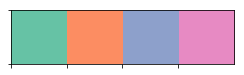

In [34]:
pal = sns.color_palette('Set2', len(np.unique(words)))
sns.palplot(pal)
word_pal = {word:pal[wordi] for wordi, word in enumerate(np.unique(words))}

In [35]:
word_pal

{'that': (0.4, 0.7607843137254902, 0.6470588235294118),
 'them': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 'then': (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 'they': (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)}

In [36]:
cols = [word_pal[i] for i in words]

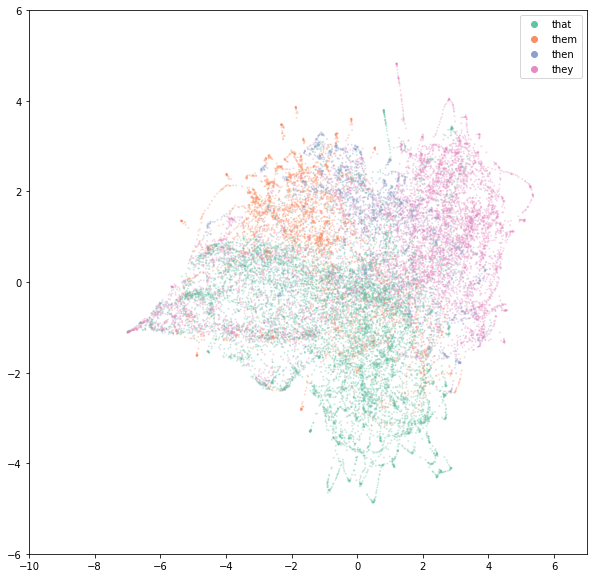

In [37]:
fig, ax = plt.subplots(figsize=(10,10))
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]
ax.legend(markers, word_pal.keys(), numpoints=1)

ax.scatter(embedding[:,0], embedding[:,1], alpha = 0.25, s = 1, color=cols)
ax.set_xlim(xlims);
ax.set_ylim(ylims);

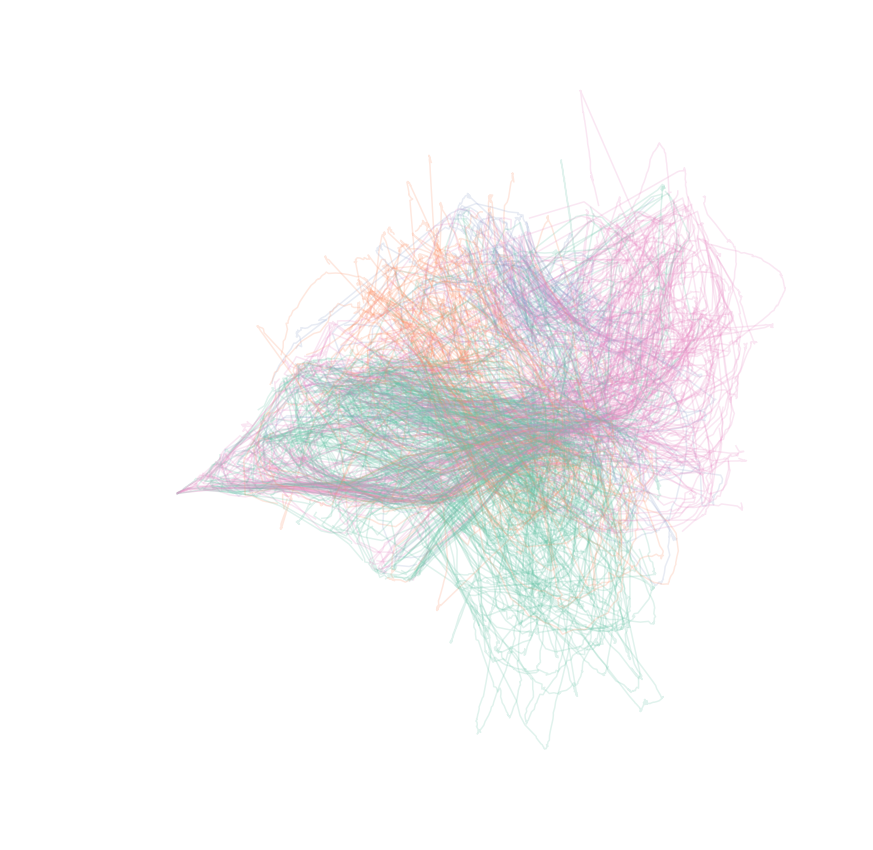

In [38]:
fig, ax = plt.subplots(figsize=(15,15))
#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]
#ax.legend(markers, word_pal.keys(), numpoints=1)

cols = [word_pal[i] for i in words]
for oi, (on, off) in enumerate(tqdm(zip(onsets, offsets), total=len(offsets))):
    window_z = embedding[on:off,:]
    ax.plot(window_z[:,0], window_z[:,1], alpha = 0.2, color=word_pal[words_df.word.values[oi]])
    #if oi > 1000:
    #    break
ax.set_xlim(xlims);
ax.set_ylim(ylims);
ax.axis('off')

if savefig: save_fig(FIG_SAVE_LOC / 'words_trajectory', save_png=True)

### plot the average over each vector for word

In [39]:
from scipy.interpolate import interp1d

In [40]:
#fig, ax = plt.subplots(figsize=(5,5))
word_list = []
word_embedding_list = []
for oi, (word, on, off) in enumerate(tqdm(zip(words_df.word, onsets, offsets), total=len(offsets))):

    window_z = embedding[on:off,:]
    
    word_list.append(word)
    
    f1 = interp1d(np.linspace(0,1, len(window_z)), window_z.T, kind='linear')
    interp_window_z = f1(np.linspace(0,1, 100)).T
    
    word_embedding_list.append(interp_window_z)
    
    #ax.scatter(window_z[:,0], window_z[:,1], alpha = 1, s = 25, color=phone_pal[phone])
    #ax.scatter(interp_window_z[:,0], interp_window_z[:,1], alpha = 1, s = 25, color=phone_pal[phone])
word_embedding_list = np.array(word_embedding_list)
word_list = np.array(word_list)

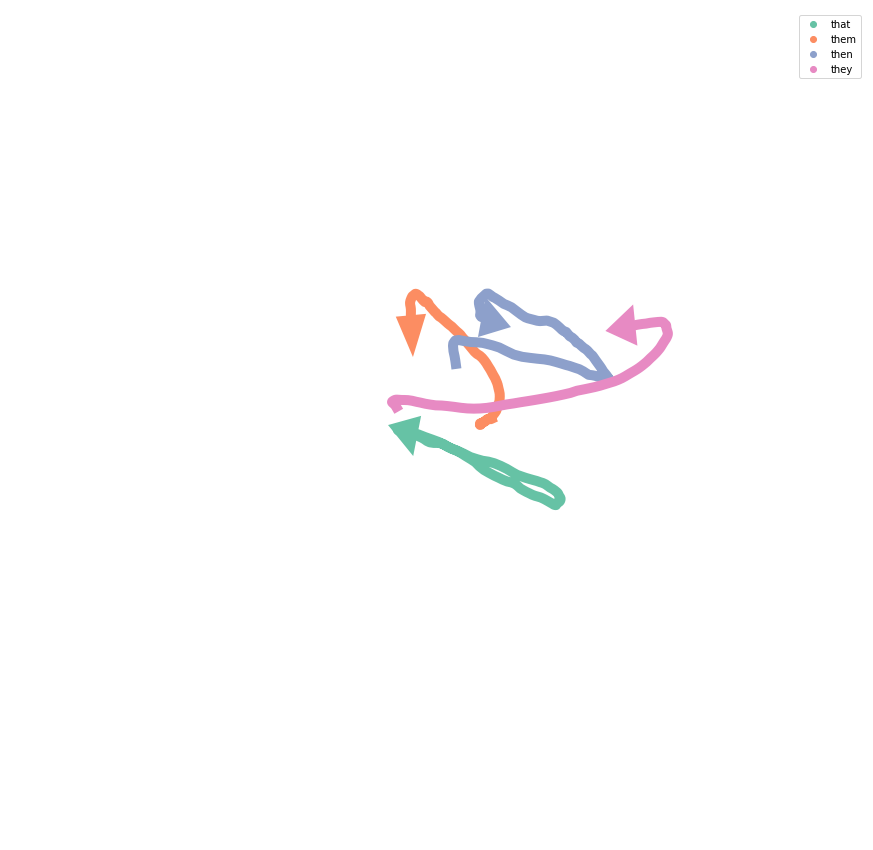

In [41]:
fig, ax = plt.subplots(figsize=(15, 15))
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]
ax.legend(markers, word_pal.keys(), numpoints=1)


for word in np.unique(word_list):
    mean_embedding = np.mean(word_embedding_list[word_list == word], axis=0)
    ax.plot(
        mean_embedding[:, 0],
        mean_embedding[:, 1],
        alpha=1,
        lw=10,
        color=word_pal[word],
    )
    ax.arrow(
        mean_embedding[-2, 0],
        mean_embedding[-2, 1],
        #mean_embedding[-1, 0] - mean_embedding[-2, 0],
        #mean_embedding[-1, 1] - mean_embedding[-2, 1],
        mean_embedding[-1, 0] - mean_embedding[-2, 0],
        mean_embedding[-1, 1] - mean_embedding[-2, 1],
        head_width=.5,
        head_length=.5,
        linewidth=4,
        color=word_pal[word],
        length_includes_head=False,
    )

ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.axis('off')
if savefig: save_fig(FIG_SAVE_LOC / 'words_vector', save_png=True, save_svg=True)

### color by phonemes

In [42]:
#make a list of phones, onsets, and offsets for each phone
# for each word, for each phone, get start time and end time in frames

In [43]:
window_length_ms = 12
hop_length_ms = 4
window_length_frames = int(window_length_ms / hop_length_ms)
window_length_frames

3

In [44]:
phones = []
phone_onsets = []
phone_offsets = []
for wdsi, (idx, row) in tqdm(enumerate(words_df.iterrows()), total= len(words_df)):
    cur_windows = len(row.windows)
    phone_start_frame = [0]
    phone_end_frame = []
    for pi, (phone, pst, pet) in enumerate(zip(row.phones, row.phone_start_times, row.phone_end_times)):
        phone_end_frame.append(int(pet / (window_length_ms / 1000)))
        if pi < len(row.phones)-1:
            phone_start_frame.append(phone_end_frame[-1]+1)
    
    phone_onsets.append(np.array(phone_start_frame) + np.sum([0] + n_windows[:wdsi]))
    phone_offsets.append(np.array(phone_end_frame) + np.sum([0] + n_windows[:wdsi]))
    phones.append(row.phones)
phones = np.concatenate(phones)    
phone_onsets = np.concatenate(phone_onsets)
phone_offsets = np.concatenate(phone_offsets)

In [45]:
print(phones[:15], phone_onsets[:15], phone_offsets[:15])

['ah' 'm' 'ae' 'dx' 'dh' 'ih' 't' 'dh' 'ih' 'dx' 'dh' 'ih' 'tq' 'dh' 'ih'] [  0   5  32  46  79  84  87 108 113 117 139 142 148 173 180] [  4  11  45  48  83  86  88 112 116 118 141 147 150 179 183]


In [46]:
common_phones = pd.DataFrame({i:[sum(phones == i)] for i in np.unique(phones)}).T.sort_values(by=0, ascending=False)[:10].T
common_phones

,dh,ey,n,ae,eh,ah,tq,t,m,ih
0,347,194,152,104,104,104,89,71,71,47


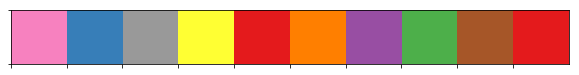

In [47]:
pal = np.random.permutation(sns.color_palette('Set1', len(common_phones.columns)))
sns.palplot(pal)
phone_pal = {word:pal[wordi] for wordi, word in enumerate(common_phones.columns)}

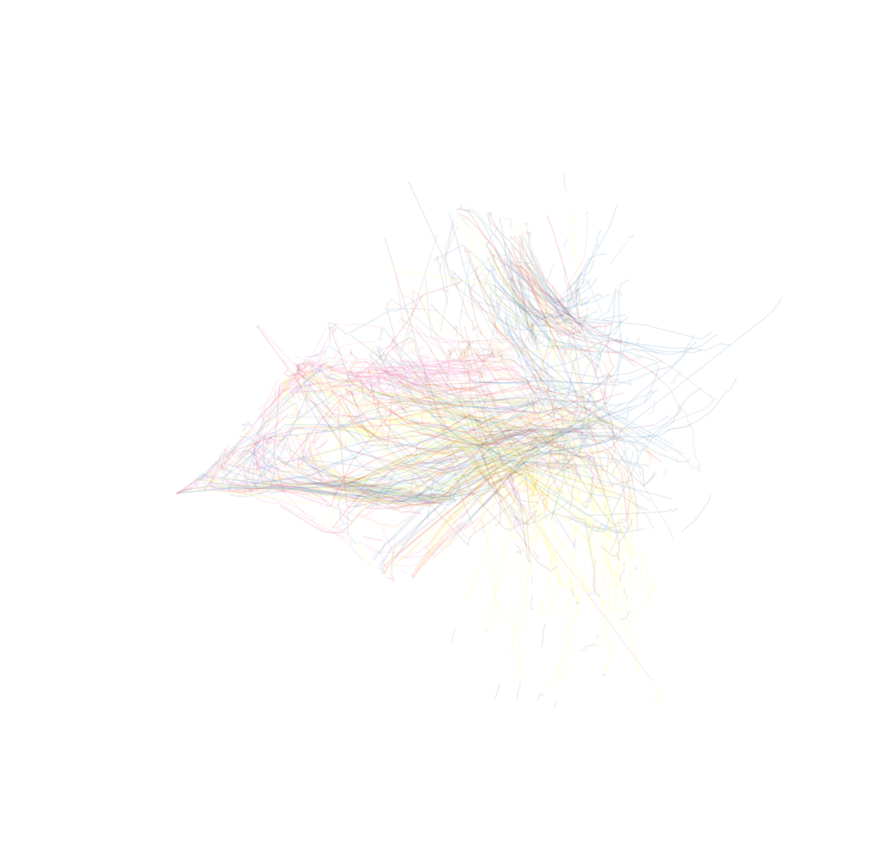

In [48]:
fig, ax = plt.subplots(figsize=(15,15))
#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in phone_pal.values()]
#ax.legend(markers, phone_pal.keys(), numpoints=1)

for oi, (phone, on, off) in enumerate(tqdm(zip(phones, phone_onsets, phone_offsets), total=len(phone_offsets))):
    if phone not in common_phones.columns:
        continue
    window_z = embedding[on:off,:]
    ax.plot(window_z[:,0], window_z[:,1], alpha = 0.1, color=phone_pal[phone])
    #if oi > 1000:
    #    break
ax.set_xlim(xlims);
ax.set_ylim(ylims);
ax.axis('off')

if savefig: save_fig(FIG_SAVE_LOC / 'phones_trajectory', save_png=True, save_svg=False)

### plot the average vector for each phone

In [49]:
len(np.linspace(0,1, len(window_z)))

2

In [50]:
np.shape(interp_window_z)

(100, 2)

In [51]:
len(window_z)

2

In [52]:
#fig, ax = plt.subplots(figsize=(5,5))
phone_list = []
embedding_list = []
for oi, (phone, on, off) in enumerate(tqdm(zip(phones, phone_onsets, phone_offsets), total=len(phone_offsets))):
    if phone not in common_phones.columns:
        continue
    window_z = embedding[on:off,:]
    if len(window_z) <2: continue
    phone_list.append(phone)
    
    f1 = interp1d(np.linspace(0,1, len(window_z)), window_z.T, kind='linear')
    interp_window_z = f1(np.linspace(0,1, 100)).T
    
    embedding_list.append(interp_window_z)
    
    #ax.scatter(window_z[:,0], window_z[:,1], alpha = 1, s = 25, color=phone_pal[phone])
    #ax.scatter(interp_window_z[:,0], interp_window_z[:,1], alpha = 1, s = 25, color=phone_pal[phone])
embedding_list = np.array(embedding_list)
phone_list = np.array(phone_list)

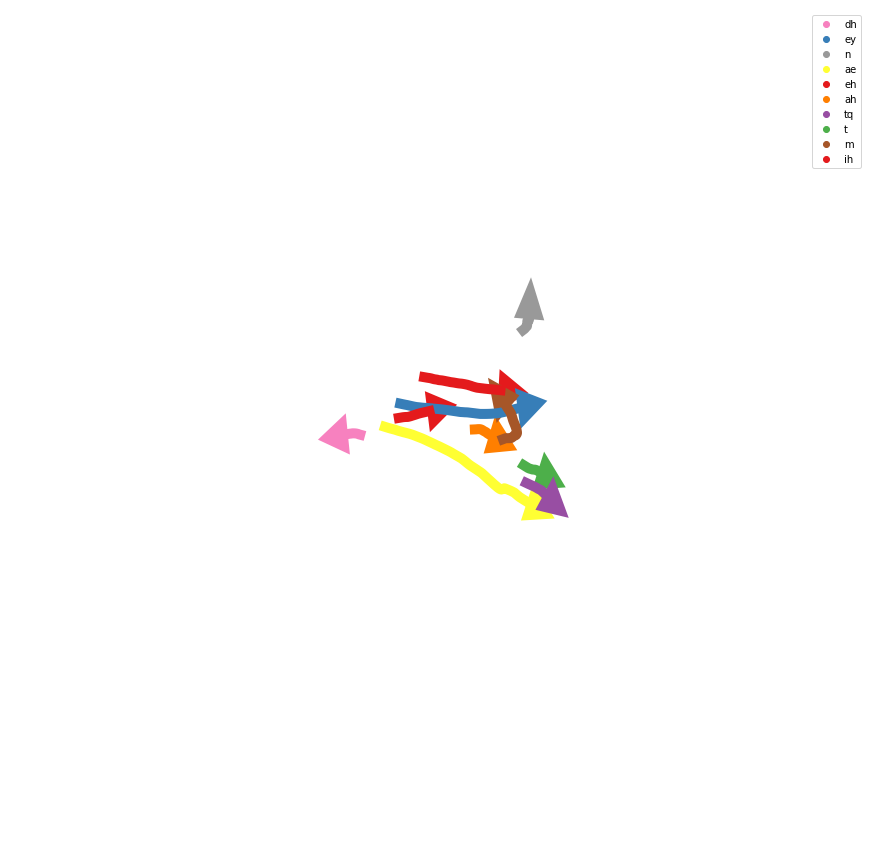

In [53]:
fig, ax = plt.subplots(figsize=(15, 15))
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in phone_pal.values()]
ax.legend(markers, phone_pal.keys(), numpoints=1)


for phone in np.unique(phone_list):
    mean_embedding = np.mean(embedding_list[phone_list == phone], axis=0)
    ax.plot(
        mean_embedding[:, 0],
        mean_embedding[:, 1],
        alpha=1,
        lw=10,
        color=phone_pal[phone],
    )
    ax.arrow(
        mean_embedding[-2, 0],
        mean_embedding[-2, 1],
        #mean_embedding[-1, 0] - mean_embedding[-2, 0],
        #mean_embedding[-1, 1] - mean_embedding[-2, 1],
        mean_embedding[-1, 0] - mean_embedding[-2, 0],
        mean_embedding[-1, 1] - mean_embedding[-2, 1],
        head_width=.5,
        head_length=.5,
        linewidth=4,
        color=phone_pal[phone],
        length_includes_head=False,
    )

ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.axis('off')

if savefig: save_fig(FIG_SAVE_LOC / 'phones_vector', save_png=True, save_svg=True)

### spectrograms vs embeddings in colorspace

In [60]:
# plot segment labels alongside phone labels

In [61]:
import copy

In [62]:
def norm(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

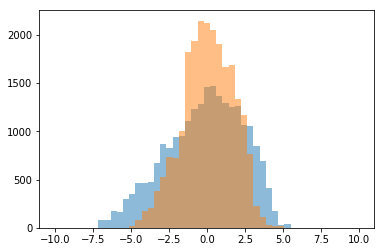

In [63]:
z_normed = copy.deepcopy(embedding)
plt.hist(z_normed[:,0], bins = np.linspace(-10,10, 50), alpha = 0.5);
plt.hist(z_normed[:,1], bins = np.linspace(-10,10, 50), alpha = 0.5);

In [68]:
xlims = [-10,5]
ylims = [-5,3]

In [69]:
z_normed[:,0][z_normed[:,0] > xlims[1]] = xlims[1]
z_normed[:,0][z_normed[:,0] < xlims[0]] = xlims[0]
z_normed[:,1][z_normed[:,1] > ylims[1]] = ylims[1]
z_normed[:,1][z_normed[:,1] < ylims[0]] = ylims[0]

z_normed[:,0] = norm(z_normed[:,0])
z_normed[:,1] = norm(z_normed[:,1])

In [70]:
window_z = z_normed
R = 1-norm(window_z[:,0])#*.75 + .25
G = 1-norm(window_z[:,1])#*.75 + .25
B = np.ones_like(G)*.5
RGB = np.dstack((R,G,B))
RGB = [list(i) for i in np.nan_to_num(np.squeeze(RGB))]
rgb_img = np.expand_dims(RGB,0)

In [71]:
phone_pal

{'dh': array([0.96862745, 0.50588235, 0.74901961]),
 'ey': array([0.21568627, 0.49411765, 0.72156863]),
 'n': array([0.6, 0.6, 0.6]),
 'ae': array([1. , 1. , 0.2]),
 'eh': array([0.89411765, 0.10196078, 0.10980392]),
 'ah': array([1.        , 0.49803922, 0.        ]),
 'tq': array([0.59607843, 0.30588235, 0.63921569]),
 't': array([0.30196078, 0.68627451, 0.29019608]),
 'm': array([0.65098039, 0.3372549 , 0.15686275]),
 'ih': array([0.89411765, 0.10196078, 0.10980392])}

In [72]:
np.shape(rgb_img)

(1, 22826, 3)

In [73]:
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import gridspec

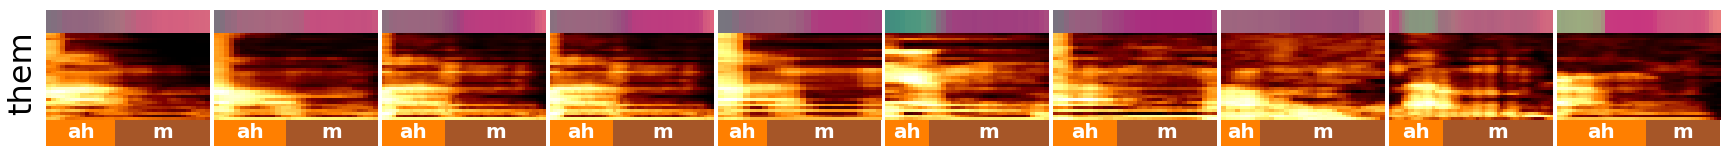

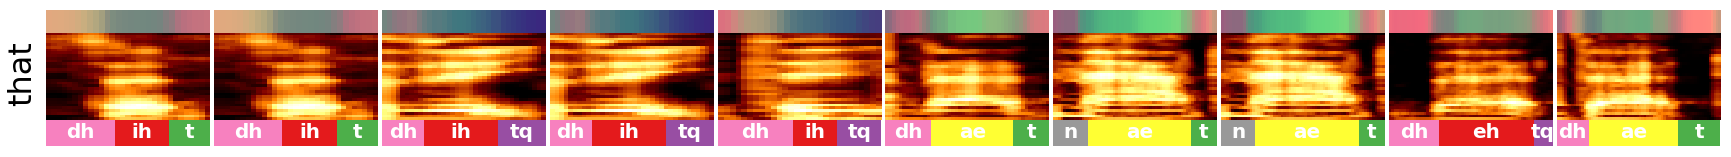

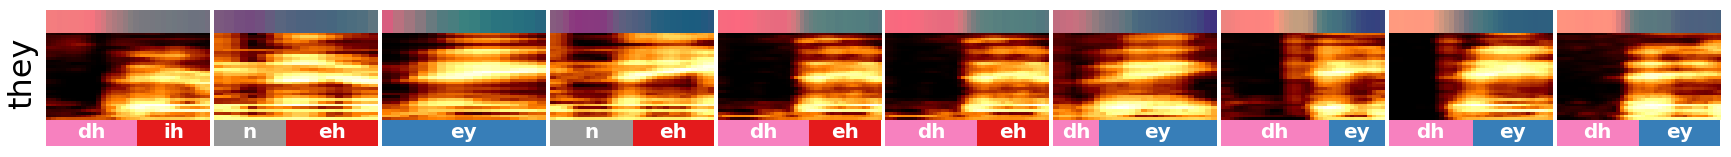

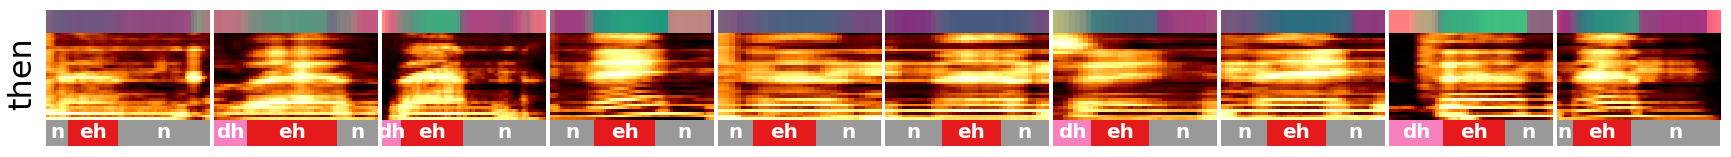

In [74]:
ncols = 10
for wi, word in enumerate(words_df.word.unique()):
    
    fig = plt.figure(figsize=((ncols)*3, 2.5)) 
    gs = gridspec.GridSpec(2, ncols, height_ratios=[1, 5]) 
    gs.update(wspace=0.025, hspace=0)
    
    for ci,col in enumerate(range(ncols)):
       
    
        row = words_df[words_df.word == word].iloc[col]
        
        while np.all([i in phone_pal for i in row.phones]) == False:
            col = col + 1
            row = words_df[words_df.word == word].iloc[col]
        
        ### plot projections
        ax = plt.subplot(gs[0, ci]) #axs[col]
        # subset embedding 
        on = onsets[np.where(words_df.index == row.name)[0][0]]
        off = offsets[np.where(words_df.index == row.name)[0][0]]

        ax.imshow(rgb_img[:,on:off, :], aspect='auto')
        
        ax.axis('off')
        ### plot spec
        ax = plt.subplot(gs[1, ci]) #axs[col]
        if ci == 0: 
            ax.set_ylabel(word, fontsize=32)
            ax.yaxis.set_label_coords(-0.05,.65)
        spec = row.spectrogram
        ax.matshow(spec, aspect='auto', origin='lower', extent = [0, row.end_time - row.start_time, 0,1], cmap = plt.cm.afmhot)
        ax.set_ylim([-.3,1])
        for spine in ax.spines:
            ax.spines[spine].set_visible(False)
        for phone, st, et in zip(row.phones, row.phone_start_times, row.phone_end_times):
            
            ax.add_patch(
            mpatches.Rectangle(
                [st, -.3],
                et - st,
                .3,
                ec="none",
                color=phone_pal[phone],
            )
            )
            ax.text((st + et)/2, -.2, phone, color='w', fontsize=20, horizontalalignment='center', weight='bold')
            
        ax.set_xticks([])
        ax.set_yticks([])
        #ax.axis('off')
    if savefig: save_fig(FIG_SAVE_LOC / ('spec_' + word), save_png=True, save_svg=True)
    plt.show()